## Learning the infinitesimal generator
Reference paper: 
- _Devergne, Kostic, Pontil, Parrinello, [J. Chem. Phys.](https://doi.org/10.1063/5.0246248) (2025), [ArXiv](https://chemrxiv.org/engage/chemrxiv/article-details/672cd8425a82cea2fa640adc)_


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/luigibonati/mlcolvar/blob/main/docs/notebooks/tutorials/adv_infinitesimal_generator.ipynb)


## Introduction
Given a system with position $x$ and mass $m$ described by the Langevin equation at an inverse temperature $\beta$ and friction $\gamma$:

$$\dfrac{dx}{dt}= -\dfrac{1}{\gamma m} \nabla U(x) + \sqrt{\dfrac{2}{\beta \gamma m}}w(t)$$

We can define the associated infinitesimal generator $\mathcal L$ which describes the relaxation from an initial probability distribution to equilibrium as follows:
$$ \dfrac{\partial u_t}{\partial t} = - \mathcal L u_t $$
Here, $u_t=p_t/\pi_B$ characterizes the deviation of the instantaneous probability distribution from the equilirbium Boltzmann distribution.
### Spectral decomposition
We will mostly be interested in the spectral decomposition of $\mathcal L$, i.e., we will look for functions $\psi_i$ that satisfy:
$$\mathcal L \psi_i = \lambda_i \psi_i$$
It can be shown that, $0=\lambda_0 \gt \lambda_1 \gt \lambda_2 \gt \dots $. The time evolution of the probability density can be written as follows:
$$ u_t(x) = \sum_i \psi_i(x) e^{-\lambda_i t } \langle u_0 | \psi_i\rangle$$
Thus, the eigenfunctions and eigenpairs characterize typical rare timescales and transitions of the system. Therefore, when interested in transitions from metastable states, we only consider the lowest part of the spectrum. The example below shows the eigenfunctions of the generator in a 4 well potential. The zero-th eigenfunction corresponds to the infinite time case, in which the system has fully relaxed to the Boltzmann distribution. The other eigenfunctions characterize the slow modes of the system. The first corresponds to the slowest mode, which is the transition between the two main basins. The remaining two eigenfunctions correspond to transitions within the sub-basins.

<center><img src="images/ef_4w.png" width="800" /></center>

### Learning the infinitesimal generator
In order to account numerical stability, we will not learn the infinitesimal generator directly, but its resolvent: $(\eta I +\mathcal L)^{-1}$, where $\eta$ is a positive number. 
Typically, when one wants to learn an operator given a basis set of function $\phi_i$, one tries to find a matrix $G$ such that $(\eta I +\mathcal L)^{-1} \phi_i \approx \sum_j G_{ij}\phi_j$. This problem has a closed-form solution, however it relies on the functions $\phi_i$. Therefore, we divide the learning into two parts. First, we learn the functions $\phi_i$ (representation learning), and then, we find the matrix $G$ and its eigenpairs.

#### Representation learning
A good representation is achieved when the functions $\phi_i$ are close to the eigenfunctions of the operator, $\mathcal L$. It can be shown that the pair $(\psi_i, \lambda_i)$ minimizes the following functional:
$$E[\{ \psi_i \};\{\lambda_i\}]=\sum_{i=0}^m\sum_{j=0}^m S_{i,j} \frac  {1}{\eta +\lambda_j} W_{ij}\frac  {1}{\eta +\lambda_i}  -  2 \sum_i^m \frac  {1}{\eta +\lambda_i} S_{i,i} + + \alpha  \text{Tr}(S^\theta-1)^2$$

The last term is added to ensure orthogonality. Here, $S_{ij}= \langle \psi_i \psi_j \rangle$ and $W_{ij}=\eta S_{ij} + \dfrac{\beta}{\gamma m} \langle \nabla \psi_i \nabla \psi_j\rangle$.
Thus, we will optimize this loss using neural networks and $\lambda_i$ as variational parameters.

After the training, one can obtain the $G$ matrix and its associated eigenvectors and values. The functions are given by:
$\psi_{i} = \sum_j v_{ij} \phi_j$, where $\phi_i$ are the functions of the learned representations and $v_i$ is the i-th eigenvector of $G$.


## Setup

In [1]:
# Colab setup
import os

if os.getenv("COLAB_RELEASE_TAG"):
    import subprocess
    subprocess.run('wget https://raw.githubusercontent.com/luigibonati/mlcolvar/main/colab_setup.sh', shell=True)
    cmd = subprocess.run('bash colab_setup.sh TUTORIAL', shell=True, stdout=subprocess.PIPE)
    print(cmd.stdout.decode('utf-8'))

# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics

# Set seed for reproducibility
torch.manual_seed(42)

### Load data

**NOTE** Here, we only showcase the workings of the code by using for convenience directly data collected from biased simulations where we have sampled the transition of interest.
In general, however, one is supposed to collect such a dataset before proceeding with the learning step.

In [2]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files
from mlcolvar.cvs.committor.utils import compute_committor_weights

################################### SET THINGS HERE ###################################
filenames = ['https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_1/A/COLVAR',
             'https://raw.githubusercontent.com/EnricoTrizio/committor_2.0/refs/heads/main/muller/biased_sims/iter_1/B/COLVAR'
            ]
load_args = [{'start' : 1000, 'stop': 10000, 'stride': 1},
             {'start' : 1000, 'stop': 10000, 'stride': 1},
            ]                     

########################################################################################

dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               create_labels=True,
                                               filter_args={'regex': 'p.x|p.y'}, # to load many positions --> 'regex': 'p[1-9]\.[abc]|p[1-2][0-9]\.[abc]'
                                               return_dataframe=True,
                                               load_args=load_args,
                                               verbose=True)

bias = torch.Tensor(dataframe['opes.bias'].values + dataframe['bias'].values)

dataset = compute_committor_weights(dataset, bias, [0,1], beta=1) # it's muller

# create datamodule with only training set
datamodule = DictModule(dataset, lengths=[1])


Class 0 dataframe shape:  (9000, 24)
Class 1 dataframe shape:  (9000, 24)

 - Loaded dataframe (18000, 24): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'z.node-0', 'z.bias-0', 'q', 'bias', '@8.bias', '@8.bias_bias', 'opes.bias', 'opes.rct', 'opes.zed', 'opes.neff', 'opes.nker', 'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'walker', 'labels']
 - Descriptors (18000, 2): ['p.x', 'p.y']


### Visualize training set

Make sure that the training set has sampled the space one wants to explore.

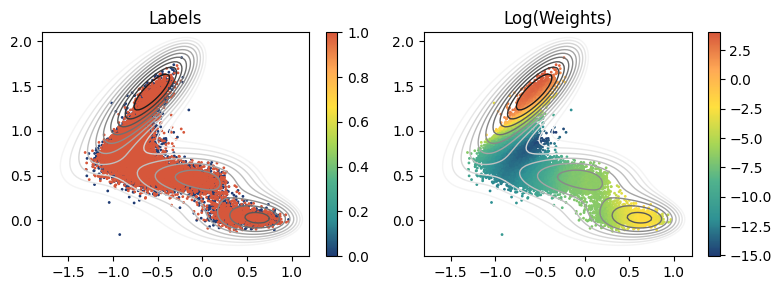

In [3]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

# plot labels
ax = axs[0]
ax.set_title('Labels')

plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=dataset['labels'], s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

# plot weights
ax = axs[1]
ax.set_title('Log(Weights)')
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), ax=ax, max_value=24, colorbar=False, mode='contour', linewidths=1)
cp = ax.scatter(dataset['data'][:, 0], dataset['data'][:, 1], c=torch.log(dataset['weights']), s=1, cmap='fessa')
plt.colorbar(cp, ax=ax)

plt.tight_layout()
plt.show()

## Initialize infinitesimal generator model and training variables

### Initialize model
Here are a few tips and tricks about the hyperparameters:
* The theoretical minimum of the loss is: $ -\sum_i{\dfrac{1}{\eta+\lambda_i}}$. Therefore, the smaller the value of the hyperparameter $\eta$, the larger the loss. Also, do not get confused if the loss is negative, this is normal.
* The hyperparameters $\eta$ and $\alpha$ are related, and in competitions: the smaller the $\eta$, the larger the first term of the loss, and thus, the larger $\alpha$ can be to ensure orthonormality. On the other hand, if $\alpha$ is too large, the learning will prioritize orthonormality.
* Beware of overfitting. These models can learn quite fast the optimal solution (from 10000 to 30000 epochs) and then overfit. This is usually indicated by a decay followed by a new plateau in the loss. If you have a validation set, you will see the validation loss increase. 

In [4]:
from mlcolvar.cvs.generator import Generator

# initialize variables
kBT = 1
masses = torch.Tensor([1.0])
n_atoms = 1
gamma = 10

# get friction
friction = kBT / (gamma*masses)
print(friction)

options = { 'nn':{'activation':'tanh'},
            'optimizer' : {'lr': 5e-4, 'weight_decay': 1e-5}}

model = Generator(r=3,
                  layers=[2,20,20,1],
                  eta=0.05,
                  alpha=0.1,
                  friction=friction,
                  n_dim=2,
                  options=options)

tensor([0.1000])


In [ ]:
# define callbacks
from mlcolvar.utils.trainer import MetricsCallback

metrics = MetricsCallback()

 # you can use a small number of epochs for testing in the range of 15/20k epochs
trainer = lightning.Trainer(callbacks=[metrics],
                            max_epochs=5, 
                            num_sanity_val_steps=0,
                            limit_val_batches=0,
                            enable_checkpointing=False,
                            enable_progress_bar = True, # disable the progress bar
                            logger=None
                            )
# fit model
trainer.fit(model, datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/etrizio@iit.local/Bin/miniconda3/envs/graph_mlcolvar_test_2.5/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type          | Params | In sizes | Out sizes
-----------------------------------------------------------------
0 | loss_fn | GeneratorLoss | 3      | ?        | ?        
1 | nn      | ModuleList    | 1.5 K  | 

### Plot metrics

The learning curve is expected to have a step-like shape. This typically indicates that your model is discovering the eigenfunctions in order of their eigenvalue magnitude, with distinct phases for each eigenfunction. Most eigenfunction learning algorithms tend to learn the dominant eigenfunctions first - those with the largest eigenvalues in magnitude. Each "step" in your learning curve corresponds to the model successfully capturing a new eigenfunction in the hierarchy. The optimization landscape naturally prioritizes eigenfunctions that correspond to the slowest modes in your dynamical system. Once a dominant eigenfunction is learned, the loss drops significantly (creating a step). The model then needs time to discover the next eigenfunction in the sequence, during which the loss plateaus.

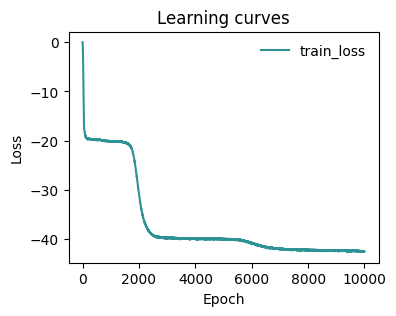

In [7]:
from mlcolvar.utils.plot import plot_metrics, paletteFessa, paletteCortina

fig, ax = plt.subplots(1,1,figsize=(4,3))
ax = plot_metrics(metrics.metrics,
                  keys=['train_loss'],
                  colors=['fessa1', 'fessa3', 'fessa4', 'fessa5'],
                  ax = ax)

## Compute eigenfunctions
Now that you have trained a representation, we can learn the generator on this representation and find the eigenfunctions
* the evals are negative, because the original generator has negative eigenvalues, so $\lambda_2 \lt \lambda_1 \lt \lambda_0=0$
* the evecs correspond to the matrix $v_{ij}$ defined above

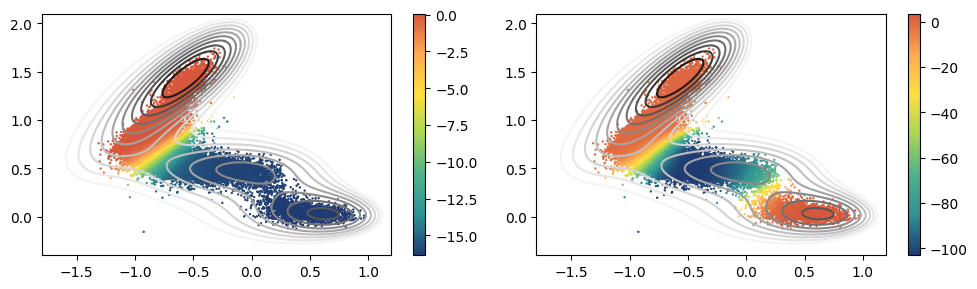

In [8]:
# compute the eigenfunctions for each point in the dataset
    # the parameters of compute_eigenfunctions are already stored in the model.
    # if you want to change them, you can pass them as args (see docstring)
eigenfunctions, evals, evecs = model.cpu().compute_eigenfunctions(dataset, friction=friction,tikhonov_reg=1e-4)

# visualize them
fig, axs = plt.subplots(ncols=2,figsize=(10,3))
for i in range(1,3):
    cp = axs[i-1].scatter(dataframe["p.x"], dataframe["p.y"], c=eigenfunctions[:,i].detach(), s=0.5, cmap='fessa')
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0, 24, 12), mode='contour', ax=axs[i-1])
    plt.colorbar(cp, ax=axs[i-1])
    
plt.tight_layout()
plt.show()

In [9]:
evals

tensor([-9.6623e-05, -2.1865e-04, -3.3477e-01])

## Forecast state occupation

### Classify points in the dataset

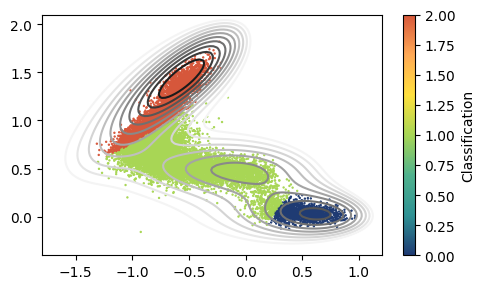

In [10]:
# this helper function helps classifying the states based on the sign of the eigenfunctions, more refined criteria can also be used
def classify_points(array):
    # Initialize classification to 10
    classification = np.ones(array.shape[0], dtype=int) * 10
    
    # Create masks for each condition
    mask_0 = ((array[:, 2] > 0.0) & (array[:, 1] < 0) ) 
    mask_1 = ((array[:, 2] < 0.0) )  
    mask_2 = (array[:, 1] > 0.0)  
    
    # Assign classifications based on conditions
    classification[mask_0] = 0
    classification[mask_1] = 1
    classification[mask_2] = 2

    # Return classification labels (replace numerical classifications)
    return classification

classification = classify_points(eigenfunctions)

fig, axs = plt.subplots(ncols=1,figsize=(5,3))
cp = axs.scatter(dataframe["p.x"], dataframe["p.y"], c=classification, s=0.5, cmap='fessa')
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0, 24, 12), mode='contour', ax=axs)
plt.colorbar(cp, label='Classification')
plt.tight_layout()

###  Compute occupation over time

We can also use eigenfunctions to compute the occupation of each state over time, given an initial distribution centered on one state. This is done using the following function:

In [11]:
from mlcolvar.cvs.generator.utils import forecast_state_occupation

start = 0.01  # A small positive number to avoid log(0)
end = 1000000
num_points = 100  # Adjust the number of points as needed

# the evolution is exponential, so we use a logarithmic scale
times = torch.logspace(np.log10(start), np.log10(end), num_points)

occupations = forecast_state_occupation(eigenfunctions, 
                              evals,
                              times, 
                              torch.Tensor(classification),
                              dataset["weights"], 
                              3)

By looking at the time evolution of the occupation of the different states, we can see how long it takes for the system to transition between the different states starting from different points of the sampled space. 

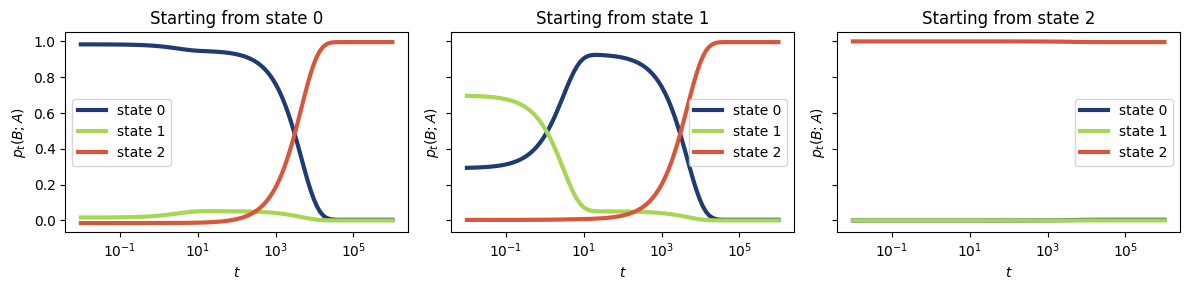

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(12,3), sharey=True)
initial_state = 0
colors = ["fessa0", "fessa3", "fessa6"]
for initial_state in range(0,3):
    for final_state in range(0,3):
        ax = axs[initial_state]
        ax.plot(times.cpu().detach(), occupations[initial_state,final_state].cpu().detach(), linewidth=3,label=f"state {final_state}", color=colors[final_state])
        ax.set_xscale("log")
        ax.set_title(f"Starting from state {initial_state}")
    ax.set_xlabel("$t$")
    ax.set_ylabel("$p_t(B;A)$")
    ax.legend()
plt.tight_layout()

### Export model with tracing

Save the trained model for future use. 

In [14]:
traced_model = model.to_torchscript(file_path='test_trace.pt', method='trace')